# Introduction

In this notebook, we are going to see various predictive models and how accurate they are in identifying whether a transaction is fraudulent or not. As described in the dataset, the features are scaled and the names of the features are hidden due to privacy concerns. Nevertheless, we can still analyze some important aspects of the dataset. Let's get started!

Data was taken from **[here](https://www.kaggle.com/mlg-ulb/creditcardfraud)**

# Our Goal
* Understand the distribution of the data that was provided to us.
* Create a 50/50 sub-data frame ratio of "Fraud" and "Non-Fraud" transactions. (NearMiss Algorithm)
* Determine the classifiers we are going to use and decide which one has higher accuracy.
* Create a neural network and compare it to our best classifier.
* Understand common mistakes made with imbalanced dataset.

# List of content
1. **[Understanding our data](#understandingOurData)**
    1. [Gather sense of our data](#understandingOurData1)
2. **[Preprocessing](#preprocessing)**
    1. [Scaling and Distribution](#preprocessing1)
    2. [Spiltting the Data](#preprocessing2)
    3. [Distribution](#preprocessing3)
    4. [Correlation](#preprocessing4)
    5. [Anomaly Detection](#preprocessing5)
3. **[Algorithm Selection](#algorithmSelection)**
    1. [Classifiers](algorithmSelection1)
    
<a style='color:black' id='understandingOurData'> 
# 1. Understanding Our Data
</a>

<a style='color:black' id='understandingOurData1'> 
## A. Gathering Sense of Our Data
</a>
The first thing we must do is gather **basic sense** of our data. Try to understand what we might be dealing with. We need to keep in mind that **we only know two columns** of the entire data, which are **transaction and amount**. We **do not know** what the **other columns** are because of privacy measures, but one thing about them is that they have **already been scaled**.

### Few Given Information About the Data by the Owner
1. **PCA Transformation:** The description of data says that all the features went through a **PCA transformation** (dimensionality reduction) except for **time** and **amount**.
You can get a better understanding of **PCA** [**here**](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c)
2. **Scaling:** In order to perform PCA Transformation on our data, the data is needed to be scaled. You can read more about scaling [**here**](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e)

**Importing Libraries**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

/home/mihir/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mihir/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mihir/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mihir/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

**Loading the Data**

In [2]:
df = pd.read_csv('../../DataSet/CreditCardFraudDataset/creditcardfraud/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Let's make sure that the data "really" doesnt have any null values.

In [4]:
df.isnull().sum().max()

0

As we can see that the data for sure doesn't have any null values.

Now let's look at all the columns we are dealing with.

In [5]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

So except for **Time** and **Amount** all the other values are **transformed and scaled**.

Let us see the distribution of the **Class** in our data and determine if it's **skewed or not**.

In [6]:
print('Not Fraudulant:', round(df.Class.value_counts()[0] / len(df) * 100, 2), '% of dataset.')
print('Fraudulant:', round(df.Class.value_counts()[1] / len(df) * 100, 2), '% of dataset.')

Not Fraudulant: 99.83 % of dataset.
Fraudulant: 0.17 % of dataset.


Notice how **imbalanced** is our original dataset! **Most** of the transactions are **not-fraud**. If we **use this dataframe** as the base for our predictive models and analysis we might **get a lot of errors** and our **algorithms** will probably **overfit** since it will **assume** that most transactions are **not fraudulant**. So if we don't run a model and just simply label every new transaction that comes inn front of us as not fraudulant, even then we will have an accuracy of **99.83%**. Which is an amazing accuracy but it doesn't really help and solve the problem in real. We **do not want our model to assume, we want our model to detect a pattern** that give signs of fraud!

Text(0.5, 1.0, 'Class Distribution \n (0: No Fraud || 1: Fraud)')

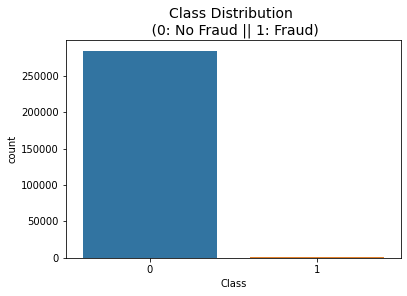

In [7]:
sns.countplot('Class', data=df)
plt.title('Class Distribution \n (0: No Fraud || 1: Fraud)', fontsize = 14)

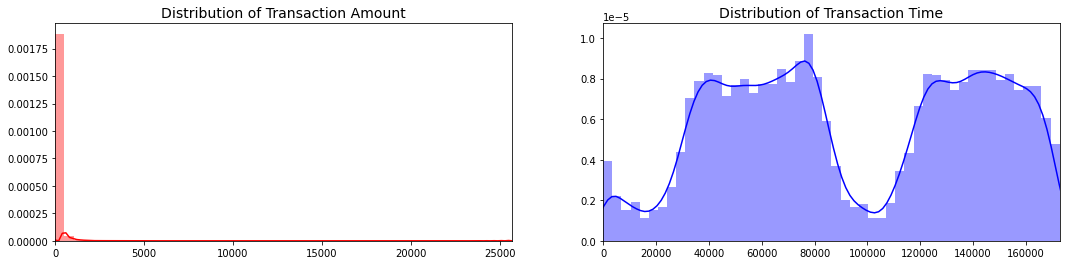

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

We can see one thing for sure after observing the **distribution** in the graphs above. The **dataset** that we have is **extremely skewed**. We can also see the distribution of other features. **Some techniques** can help the distributions **be less skewed** which we are going to implement later in this notebook.

<a style='color:black' id='preprocessing'> 
# 2. Preprocessing
</a>
Data preprocessing is an important step in the data mining process. The phrase **"garbage in, garbage out"** is particularly applicable to data mining and machine learning projects.

<a style='color:black' id='preprocessing1'> 
## A. Scaling and Distribution
</a>

In this section of our notebook, we will **first scale** the **non-scaled columns which are Time and Amount**. Time and Amount should be scaled as the other columns in the data frame. On the other hand, we need to also create a **sub-sample** of the data frame to have an **equal number of "Fraud" and "Non-Fraud"** cases, helping our algorithms understand patterns better and help determine whether a transaction is a fraud or not.

**What is a sub-sample?**
In this scenario, our sub-sample will be a dataframe with a **50:50 ratio** of fraud and non-fraud transactions. Meaning our sub-samples will have the same amount of fraud and non-fraud transactions.

**Why do we create a sub-sample?**
In the earlier section of this notebook, we observed that the dataframe was heavily imbalanced! Using the original dataframe will cause the following issues:
1. **[Overfitting](https://www.investopedia.com/terms/o/overfitting.asp):** Our classification models will assume that in most cases there are no frauds! What we want for our model is to be certain when a fraudulent transaction occurs.
2. **[Wrong Correlation](https://www.investopedia.com/terms/c/correlation.asp):** Although we don't know what the "V" features in the dataframe stand for, it will be useful to understand and incorporate how each of these features influences the result (fraud or non-fraud). By having an imbalance dataframe we are not able to see the true correlations between the classes and the features.

**What we are going to do in this section?**
* **Scaled amount and time** to match the other variables in the dataframe.
* There are **0.17% of fraudulent cases** in our dataset. So we need **an equal number of non-fraudulent cases** to create our new **sub dataframe**.
* **Concat** the equal number of fraudulent and non-fraudulent cases and create out new subsample.

Since most of the data has already been scaled we should also scale the **amount and time** columns to match the rest.

To scale the data there are various techniques such as: 
1. **Standard Scalar Transformation**, 
2. **Min-Max Scalar Transformation**, 
3. **Max-Abs Scalar Transformation**, etc. 

But of the above-mentioned scalar, all of them are **sensitive to the outliers**. As we know our task is the detection of outliers the above scaling techniques won't work. So for that, we are going to use **Robust Scalar Transformation**. This scaling technique is **based on percentile** and therefore isn't influenced by a few numbers of very large outliers. If you want so see a detailed comparison of all the different scalar techniques you can check them **[here](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html)**

In [9]:
from sklearn.preprocessing import RobustScaler

robust_scalar = RobustScaler()

df['scaled_amount'] = robust_scalar.fit_transform(
    df['Amount'].values.reshape(-1, 1)
) #Scaling Amount

df['scaled_time'] = robust_scalar.fit_transform(
    df['Time'].values.reshape(-1, 1)
) #Scaling Time

df.drop(['Time', 'Amount'], axis=1, inplace=True) #Removing Amount and time from the dataframe

#Making scaled_amount and scaled_time the first two columns of the dataframe

scaled_amount = df['scaled_amount'] 
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


Now we get to our next part of the section:

<a style='color:black' id='preprocessing2'> 
## B. Splitting the Data
</a>

Before we proceed with the **[Random Undersampling or Oversampling Technique](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/)** we have to separate the original dataframe.
**Why?**
**Because for testing purposes. Remember although we are splitting the data by implementing Random Undersampling or Oversampling techniques we want to test our models on the testing set created from the original dataset and not on the testing set created by either of the aforementioned techniques**. The main idea behind doing this is to fit our model either with the dataframes that were undersampled or oversample and test it on the original testing set.

For splitting we will be using `StratifiedKFold` which is a modification of **k-fold cross-validation** technique. You can get an idea of the difference in k-fold and Stratified k-Fold **[here](https://medium.com/@xzz201920/stratifiedkfold-v-s-kfold-v-s-stratifiedshufflesplit-ffcae5bfdf)**

In [10]:
X = df.drop('Class', axis = 1)
y = df.Class

skf  = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in skf.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    originalXTrain, originalXTest = X.loc[train_index], X.loc[test_index]
    originalYTrain, originalYTest = y.loc[train_index], y.loc[test_index]
    
originalXTrain = originalXTrain.values
originalXTest = originalXTest.values
originalYTrain = originalYTrain.values
originalYTest = originalYTest.values

trainUniqueLabel, trainCountsLabel = np.unique(originalYTrain, 
                                               return_counts=True)

testUniqueLabel, testCountLabel = np.unique(originalYTest,
                                           return_counts=True)

print('Label Distributions: \n')
print(trainCountsLabel / len(originalYTrain))
print(testCountLabel / len(originalYTest))

Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


After splitting our data we will move on to sampling.

<a style='color:black' id='preprocessing3'> 
## C. Distribution
</a>

We have already discussed **random sampling**. We will be using **Random Under-Sampling**. **Random Under-Sampling** is removing data to have a more **balanced** dataset and thus avoiding our models to **overfitting**. 

Our approach to **Random Under Sampling**:
1. The first thing that we are going to do is to determine how **imbalanced** our dataset is. We can use `value_counts()` on the column `Class` of the dataset to determine the count.
2. Once we determine how many instances of fraudulent transactions are there in the dataset, we need to bring down the non-fraudulent instances to the same amount of fraudulent transactions (as we want 50/50 ratio).
3. The next step will be to implement shuffle to the data and see if our model can maintain an acceptable accuracy every time we run the script.

<span style='color:gray'> 
**Note: The main issue with "Random Under-Sampling" is that we run the risk that our classification models will not perform as accurate as we would like to since there is a great deal of information loss.**
</span>

In [11]:
#Let's shuffle the data

df = df.sample(frac=1) 

fraud_df = df[df.Class == 1]
non_fraud_df = df[df.Class == 0][:492]

normal_distribution_df = pd.concat([fraud_df, non_fraud_df])

new_df = normal_distribution_df.sample(frac=1, random_state = 42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
232037,-0.282401,0.732222,2.136310,0.000205,-1.477627,0.161809,0.458904,-0.593398,0.235652,-0.329687,...,-0.121661,-0.345217,-0.802217,0.198786,-0.974153,-0.123182,0.256782,-0.065047,-0.068164,0
6334,-0.293440,-0.906460,0.026779,4.132464,-6.560600,6.348557,1.329666,-2.513479,-1.689102,0.303253,...,0.587743,0.370509,-0.576752,-0.669605,-0.759908,1.605056,0.540675,0.737040,0.496699,1
162633,-0.243974,0.359109,-0.393794,0.325192,1.258356,-0.907171,0.540286,0.491162,0.093136,0.267254,...,-0.026953,0.246171,0.807966,-0.342650,-1.030505,-0.288695,0.583451,0.123408,0.140159,0
623,7.084469,-0.989438,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,...,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,1
190368,2.150493,0.518227,-2.272473,2.935226,-4.871394,2.419012,-1.513022,-0.480625,-2.126136,1.883507,...,-0.031085,0.718504,0.893850,-0.031632,0.322913,-0.058406,-0.411649,0.573803,0.176067,1


Distribution of the Classes in the subsample dataet
1    0.5
0    0.5
Name: Class, dtype: float64


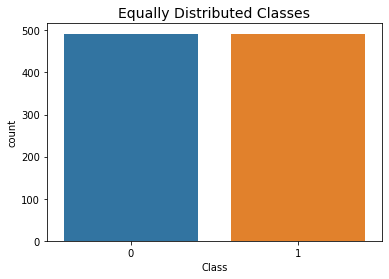

In [12]:
print('Distribution of the Classes in the subsample dataet')
print(new_df['Class'].value_counts() / len(new_df))

sns.countplot('Class', data=new_df)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

Now that are dataframe is equally distributed, we can go further with our analysis and data preprocessing.

<a style='color:black' id='preprocessing4'> 
## D. Correlation
</a>

**Correlation matrices** are the essence of understanding our data. We want to know if any **features strongly influence** whether a transaction being a fraud. However, we must use the correct dataframe (sub-sample) to see which features impact the results.

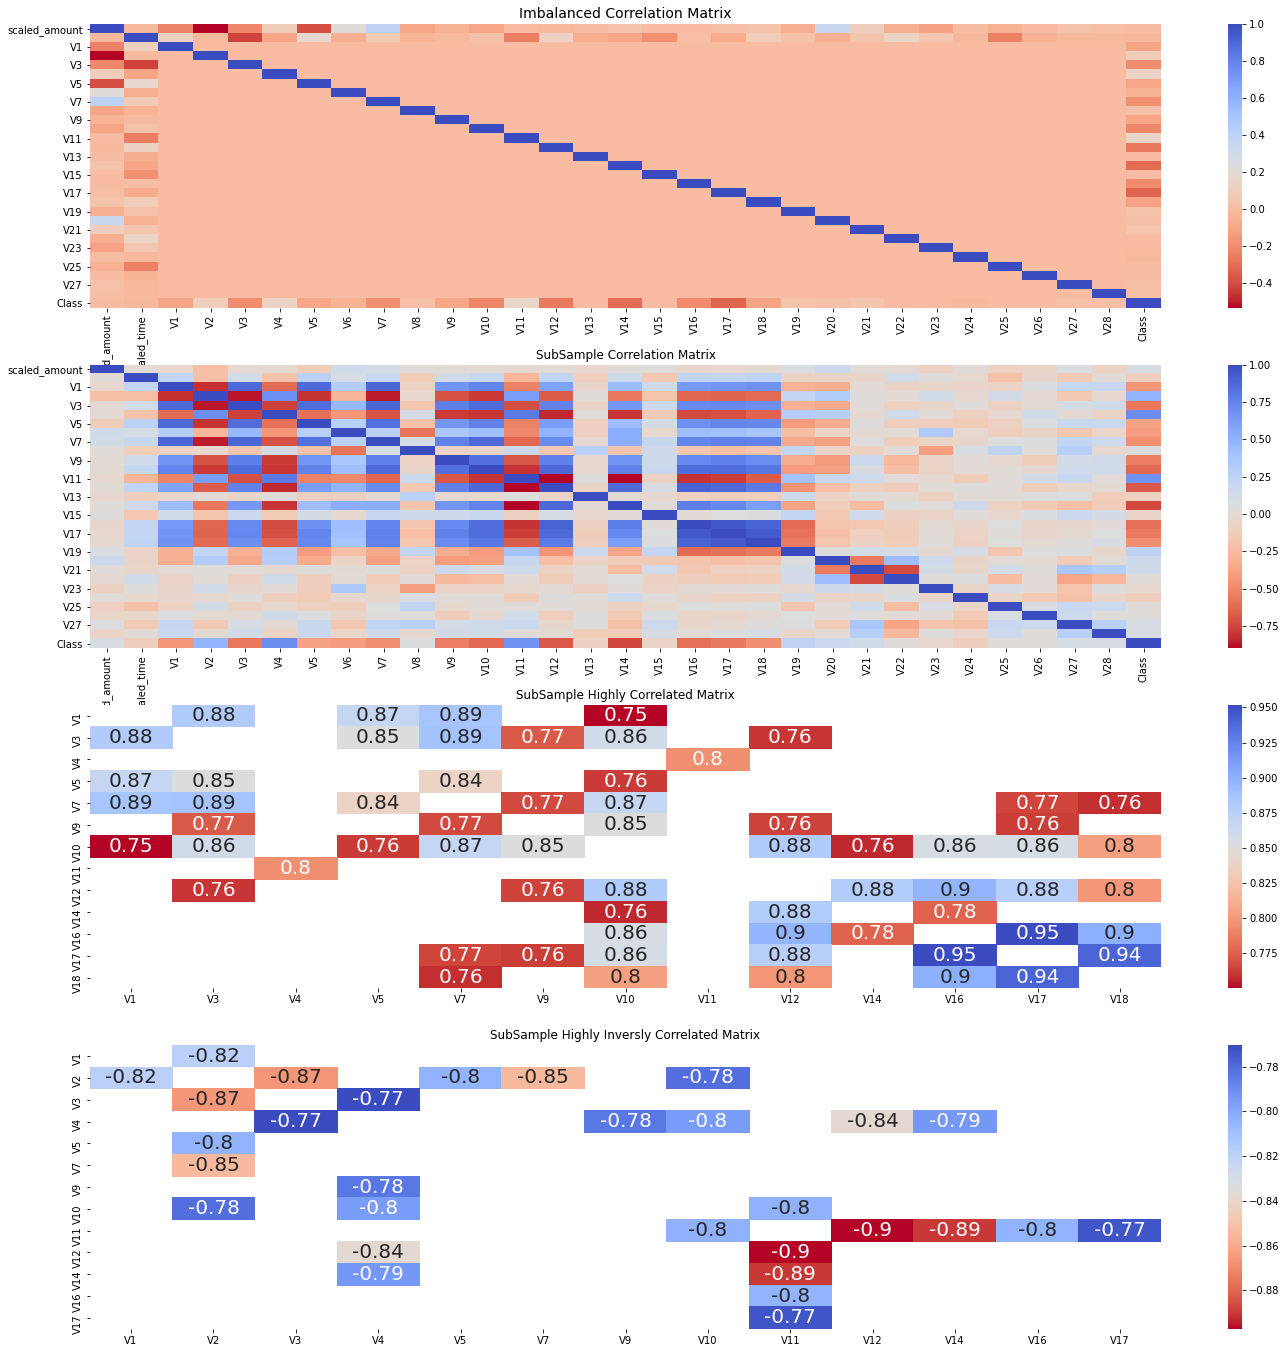

In [13]:
fig, axes = plt.subplots(4, 1, figsize=(24,24))

corr = df.corr()

sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=axes[0])
axes[0].set_title('Imbalanced Correlation Matrix', fontsize=14)

sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=axes[1])
axes[1].set_title('SubSample Correlation Matrix')

sns.heatmap(
    sub_sample_corr[(sub_sample_corr > 0.75) & (sub_sample_corr < 1)].dropna(how='all').dropna(how='all', axis = 1),
    cmap='coolwarm_r',
    annot_kws={'size':20},
    annot=True,
    ax=axes[2]
)
axes[2].set_title('SubSample Highly Correlated Matrix')

sns.heatmap(
    sub_sample_corr[sub_sample_corr < -0.75].dropna(how='all').dropna(how='all', axis = 1),
    cmap='coolwarm_r',
    annot_kws={'size':20},
    annot=True,
    ax=axes[3]
)
axes[3].set_title('SubSample Highly Inversly Correlated Matrix')

plt.show()

In [14]:
neg_correlated = sub_sample_corr.Class.sort_values()[:4]
pos_correlated = sub_sample_corr.Class.sort_values()[-3:-1]
neg_correlated_index = neg_correlated.index
pos_correlated_index = pos_correlated.index
print(neg_correlated_index)
print(pos_correlated_index)
print(pos_correlated[::-1], neg_correlated)

Index(['V14', 'V12', 'V10', 'V16'], dtype='object')
Index(['V11', 'V4'], dtype='object')
V4     0.707185
V11    0.682949
Name: Class, dtype: float64 V14   -0.748816
V12   -0.684601
V10   -0.628921
V16   -0.594474
Name: Class, dtype: float64


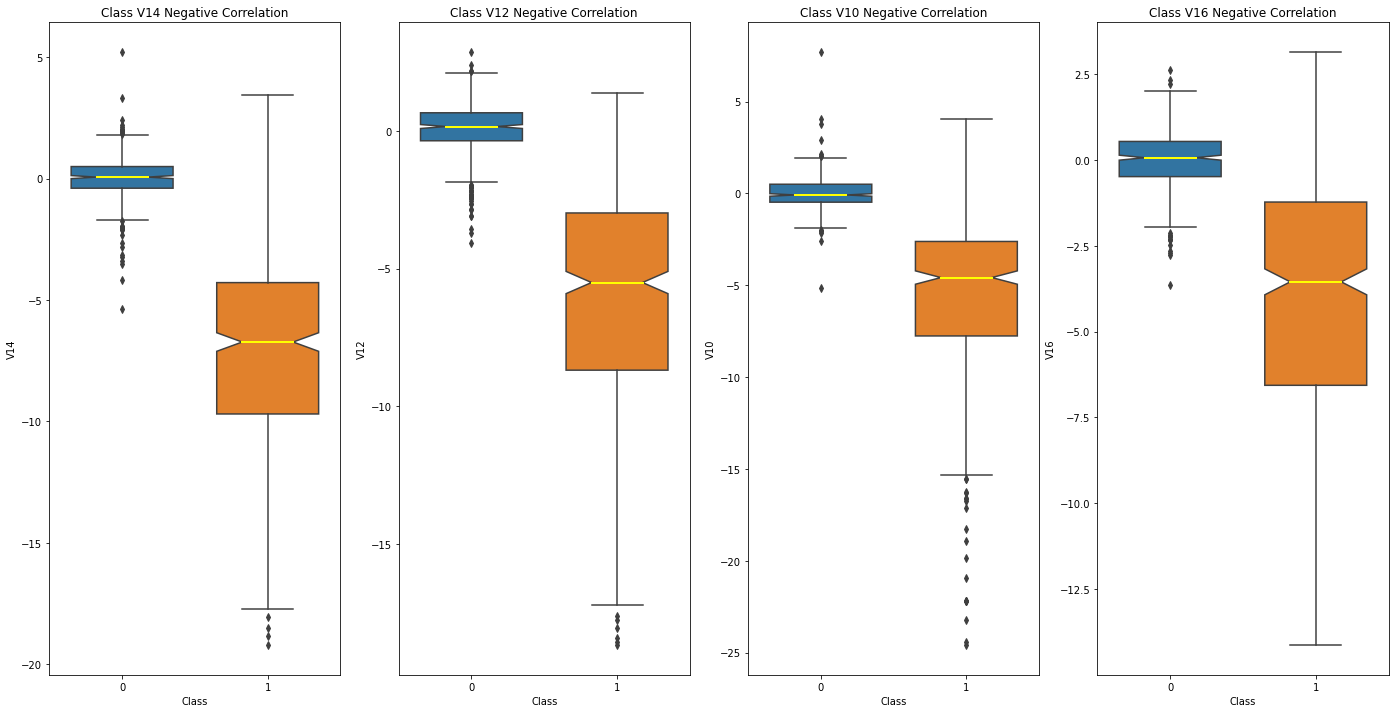

In [15]:
fig, axes = plt.subplots(ncols=len(neg_correlated), figsize=(24,12))

for i in range(len(neg_correlated)):
    sns.boxplot(
        x='Class', 
        y=neg_correlated_index[i], 
        data=new_df, 
        ax=axes[i],
        width=0.7,
        notch=True,
        medianprops={
            'linestyle':'-',
            'linewidth':2,
            'color':'Yellow'
        }
    )
    axes[i].set_title('Class '+neg_correlated_index[i]+' Negative Correlation')

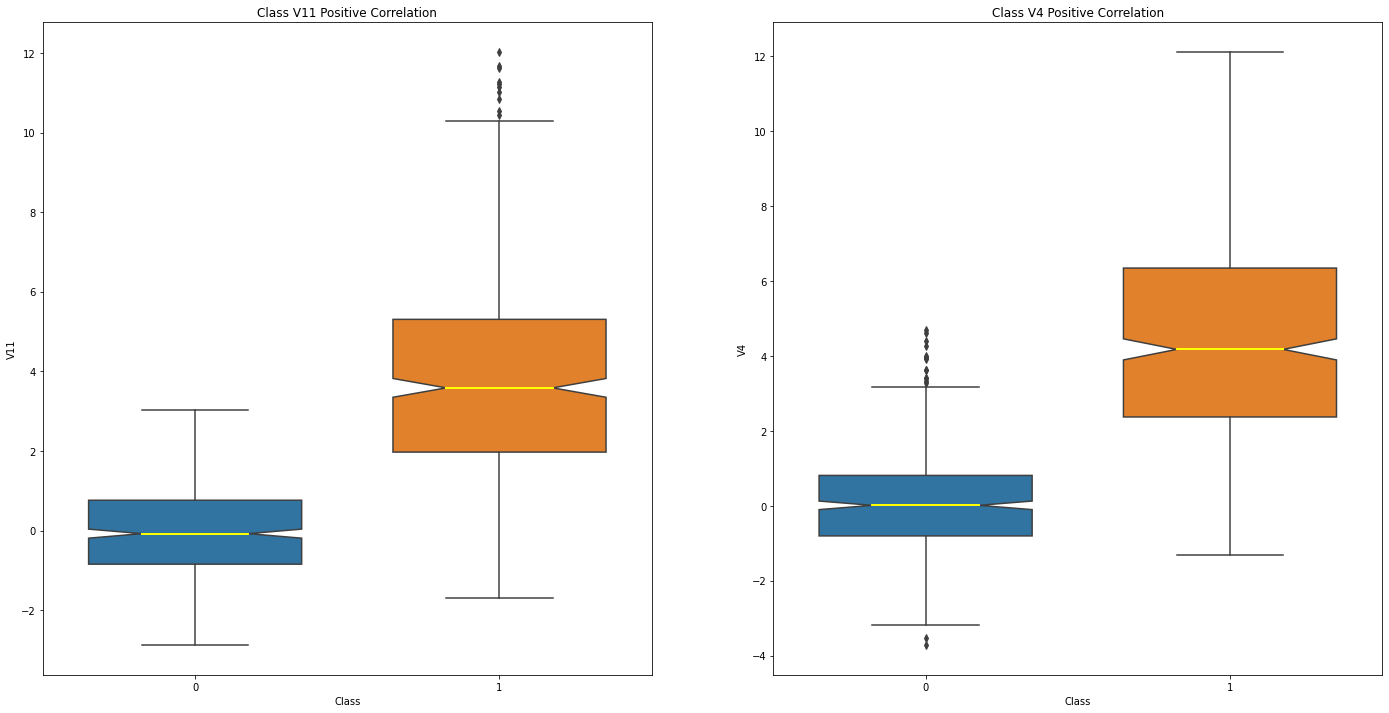

In [16]:
fig, axes = plt.subplots(ncols=len(pos_correlated), figsize=(24,12))

for i in range(len(pos_correlated)):
    sns.boxplot(
        x='Class', 
        y=pos_correlated_index[i], 
        data=new_df, 
        ax=axes[i],
        width=0.7,
        notch=True,
        medianprops={
            'linestyle':'-',
            'linewidth':2,
            'color':'Yellow'
        }
    )
    axes[i].set_title('Class '+pos_correlated_index[i]+' Positive Correlation')

**Observations:**
1. As we can see that the **notches in the [boxplots](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51) do not overlap**, you can conclude that with **95% confidence**, that the **true median do differ**.
2. V10, V12 and V16 are **negatively correlated**. Notice how the lower these values are, the more likely the result will be a fraudulent transaction.
3. V4 and V11 are **positively correlated**. Notice how the higher these values are, the more likely the result will be a fraudulent transaction.

Note: We have to make sure to **use subsamples in our correlation** matrix, or else our correlation matrix will be affected by the high imbalance between our classes. This occurs due to the high-class imbalance

<a style='color:black' id='preprocessing5'> 
## E. Anomaly Detection
</a>

Our main aim in this section is to remove **extreme outliers** from the features that we had a high correlation with our classes. This will have a positive impact on the accuracy of our model.

### Outlier Removal Tradeoff:
We have to be careful as to how we tread with the threshold for removing outliers. We determine the threshold by multiplying a number, for example, 1.5, by the interquartile range. The higher the threshold, the lesser the outliers we will be able to detect and vice versa.

**The Tradeoff:** The lower the threshold the more outliers it will remove however, we want more focus on **extreme outliers** rather than just outliers. Why do you ask?  Because we might run the risk of information loss which will cause our models to have lower accuracy. You can play with this threshold and see how it affects the accuracy of our classification models.

**Steps we are going to take:**
1. **Visualization Distributions:** We first start by visualizing the distributions of the features we are going to use to eliminate some of the outliers.
2. **Determining the Threshold:** After we decide which numbers we will use to multiply with the IQR, we will proceed to determine the upper and lower thresholds by deducting the threshold from the lower quartile and adding the threshold to the upper quartile.
3. **Conditional Dropping:** Lastly, we create a conditional dropping stating that if the *threshold* is exceeding in both the extremes, the instances will be removed.
4. **Boxplot Representation:** Visualize through the boxplot that the number of *extreme outliers* has been reduced to a considerable amount. 

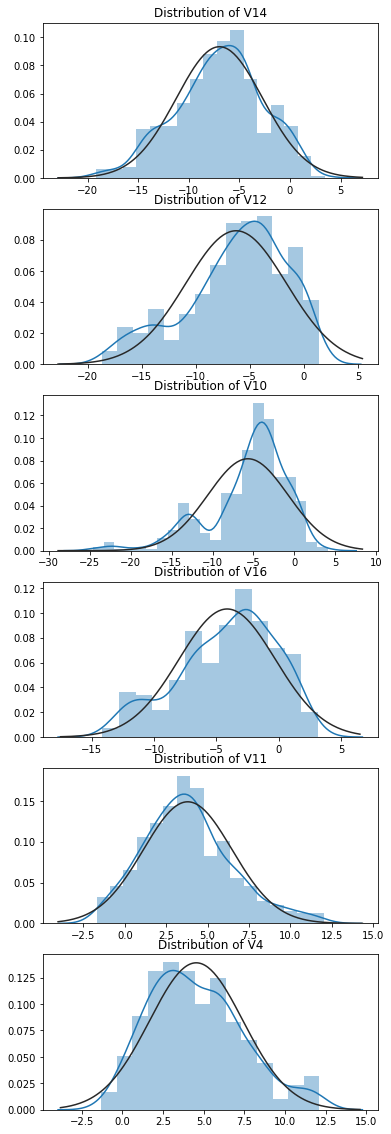

In [17]:
from scipy.stats import norm

temp = neg_correlated_index.to_list() + pos_correlated_index.to_list()

fig, axes = plt.subplots(nrows=len(temp), figsize=(6, 20))

for each in range(len(temp)):
    fraud_dist = new_df[temp[each]].loc[new_df.Class == 1].values
    sns.distplot(fraud_dist, ax=axes[each], fit=norm)
    axes[each].set_title('Distribution of '+temp[each])

In [18]:
total = len(new_df)
for i in range(len(temp)):
    v_fraud = new_df[temp[i]].loc[new_df.Class == 1].values
    q25, q75 = np.percentile(v_fraud, 25), np.percentile(v_fraud, 75)
    print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
    v_iqr = q75 - q25
    print('IQR: {}'.format(v_iqr))
    
    v_cut_off = v_iqr * 1.5
    v_lower, v_upper = q25 - v_cut_off, q75 + v_cut_off
    print('Cut Off: {}'.format(v_cut_off))
    print(temp[i] + ' Lower: {}'.format(v_lower))
    print(temp[i] + ' Upper: {}'.format(v_upper))
    
    outliers = [x for x in v_fraud if x < v_lower or x > v_upper]
    print('Features '+temp[i]+ ' Outliers for fraud Cases: {}'.format(len(outliers)))
    print(temp[i] + ' Outliers: {}'.format(outliers))
    
    new_df = new_df.drop(new_df[(new_df[temp[i]] > v_upper) | (new_df[temp[i]] < v_lower)].index)
    print('---'*45)
    
print('Outliers removed: {}'.format(total - len(new_df)))

Quartile 25: -9.692722964972385 | Quartile 75: -4.282820849486866
IQR: 5.409902115485519
Cut Off: 8.114853173228278
V14 Lower: -17.807576138200663
V14 Upper: 3.8320323237414122
Features V14 Outliers for fraud Cases: 4
V14 Outliers: [-18.8220867423816, -18.049997689859396, -19.2143254902614, -18.4937733551053]
---------------------------------------------------------------------------------------------------------------------------------------
Quartile 25: -8.67303320439115 | Quartile 75: -2.893030568676315
IQR: 5.780002635714835
Cut Off: 8.670003953572252
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
Features V12 Outliers for fraud Cases: 4
V12 Outliers: [-18.4311310279993, -18.047596570821604, -18.553697009645802, -18.683714633344298]
---------------------------------------------------------------------------------------------------------------------------------------
Quartile 25: -7.466658535821848 | Quartile 75: -2.5118611381562523
IQR: 4.954797397665596
Cut Off: 7.43219

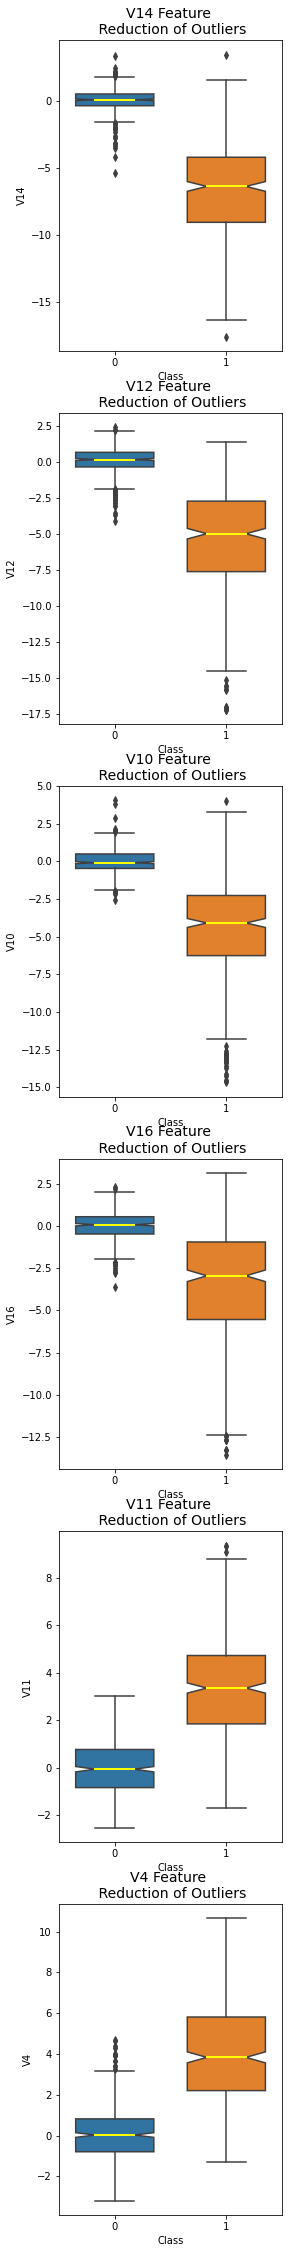

In [19]:
fig, axes = plt.subplots(nrows=len(temp), figsize=(4, 40))

for i in range(len(temp)):
    sns.boxplot(
        x='Class',
        y=temp[i],
        data=new_df,
        ax=axes[i],
        width=0.7,
        notch=True,
        medianprops={
            'linestyle':'-',
            'linewidth':2,
            'color':'Yellow'
        }
    )
    axes[i].set_title(temp[i] + ' Feature \n Reduction of Outliers', fontsize = 14)

**Conclusion:**
We were able to eliminate **61** outliers from our dataframe.

<a style='color:black' id='preprocessing6'> 
## F. Dimensionality  Reduction and Clustering
</a>

### Understanding [<span style='color:black'>t-SNE</span>](https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1)

In order to understand this algorithm you have to understand the following terms.
* **[Euclidean Distance](http://rosalind.info/glossary/euclidean-distance/)**
* **[Conditional Probability](https://www.statisticshowto.com/what-is-conditional-probability/)**
* **[Normal](https://www.investopedia.com/terms/n/normaldistribution.asp) and [t-Distribution](https://www.investopedia.com/terms/t/tdistribution.asp)**

In [20]:
X = new_df.drop('Class', axis=1)
y = new_df.Class

#t-SNE implementation
t0 = time.time()
X_reduced_tsne = TSNE(
    n_components=2, 
    random_state=42
).fit_transform(X.values)
t1 = time.time()
print('t-SNE took {:.2} s'.format(t1-t0))

#PCA implementation
t0 = time.time()
X_reduced_pca = PCA(
    n_components=2, 
    random_state=42
).fit_transform(X.values)
t1 = time.time()
print('PCA took {:.2} s'.format(t1-t0))

#TruncatedSVD implementation
t0 = time.time()
X_reduced_truncated_svd = TruncatedSVD(
    n_components=2, 
    algorithm='randomized',
    random_state=42
).fit_transform(X.values)
t1 = time.time()
print('Truncated SVD took {:.2} s'.format(t1-t0))

t-SNE took 8.3 s
PCA took 0.057 s
Truncated SVD took 0.026 s


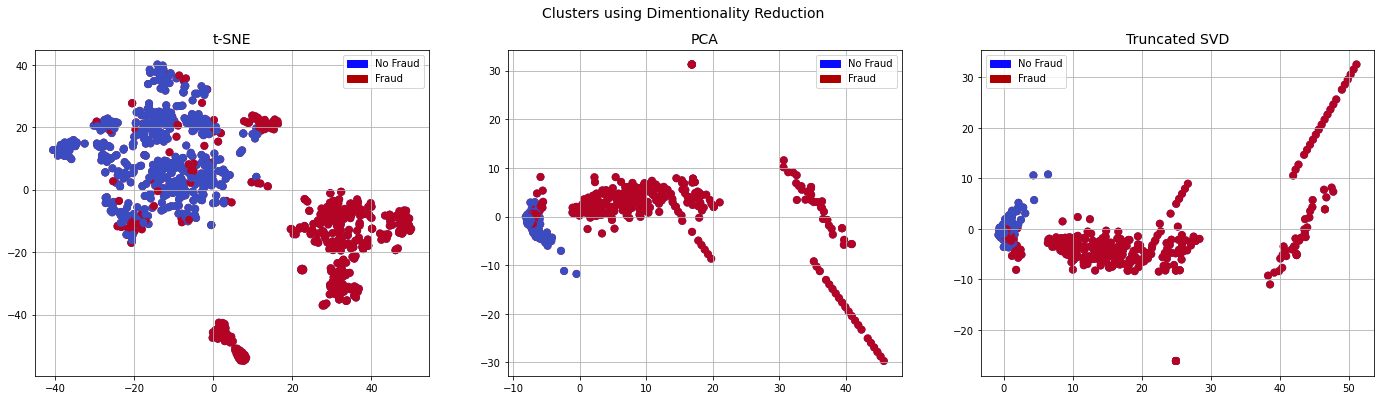

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(24, 6))

fig.suptitle('Clusters using Dimentionality Reduction', fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

#t-SNE scatter plot
ax1.scatter(
    X_reduced_tsne[:,0], 
    X_reduced_tsne[:,1], 
    c=(y == 0), 
    cmap='coolwarm',
    label='No Fraud', 
    linewidths=2
)
ax1.scatter(
    X_reduced_tsne[:,0],
    X_reduced_tsne[:,1],
    c=(y == 1),
    cmap='coolwarm',
    label='No Fraud',
    linewidths=2
)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])

#PCA scatter plot
ax2.scatter(
    X_reduced_pca[:,0],
    X_reduced_pca[:,1],
    c=(y == 0),
    cmap='coolwarm',
    label='No Fraud',
    linewidth=2
)
ax2.scatter(
    X_reduced_pca[:,0],
    X_reduced_pca[:,1],
    c=(y == 1),
    cmap='coolwarm',
    label='Fraud',
    linewidth=2
)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

#Truncated SVD scatter plot
ax3.scatter(
    X_reduced_truncated_svd[:,0],
    X_reduced_truncated_svd[:,1],
    c=(y == 0),
    cmap='coolwarm',
    label='No Fraud',
    linewidth=2
)
ax3.scatter(
    X_reduced_truncated_svd[:,0],
    X_reduced_truncated_svd[:,1],
    c=(y == 1),
    cmap='coolwarm',
    label='Fraud',
    linewidth=2
)
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

plt.show()

**Conclusion:**
1. The **t-SNE algorithm** is evidently better to cluster the cases in their respective category, much **better than PCA and Truncated SVD**.
2. This was possible even when the size of the sub-sample was small.

<span id='slgorithmSelection' style='color:black'> 
# 3. Algorithm Selection
</span>

**What is Model Selection?**

Model selection is the process of selecting one final machine learning model from amongst a collection of potential candidates of machine learning dataset.

Model selection is a process that can be applied both across different types of models (e.g. logistic regression, SVM, KNN, etc.) and across models of the same type, configured with different hyper-parameters (e.g. different kernels in an SVM)

**Model Selection** is the process of choosing one of the models as the final model that addressed the problem.

<span id='algorithmSelection1' style='color:black'> 
## A. Potential Models
</span>

There is an important difference between classification and regression problems.

Fundamentally, classification is about picking a label and regression is about predicting a quantity.

As we have to select one of the two labels assigned to our data set, **Fraud and Non-fraud** we are dealing with a classification problem.

**We will be using the following classification model for our dataset:**
1. _[Logistic Regression](https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc)_
2. _[K-Nearest Neighbor](https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761)_
3. _[Support Vector Classifier](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47)_
4. _[Decision Tree Classifier](https://towardsdatascience.com/decision-tree-classification-de64fc4d5aac)_

In [22]:
X = new_df.drop('Class', axis=1)
y = new_df.Class

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [25]:
classifiers = {
    'LogisticRegression': LogisticRegression(),
    'KNearestNeighbor': KNeighborsClassifier(),
    'SupportVectorClassifier': SVC(),
    'DecisionTreeClassifier': DecisionTreeClassifier()
}

In [26]:
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X=X_train, y=y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    
    print('Classifiers:', classifier.__class__.__name__, 'has a training score of', round(training_score.mean(), 3) * 100, '% accuracy score')

Classifiers: LogisticRegression has a training score of 93.89999999999999 % accuracy score
Classifiers: KNeighborsClassifier has a training score of 93.0 % accuracy score
Classifiers: SVC has a training score of 93.4 % accuracy score
Classifiers: DecisionTreeClassifier has a training score of 90.7 % accuracy score


<span id='algorithmSelection2'> 
## B. Finding Best Parameters
</span>

The second part of the model selection process is to select a set of hyperparameters that work the best for our models. 

To determine the right hyperparameters, there is no better way than permutations and combinations.

To simplify the process and save our selves a lot of time, we will be using a scikit-learn library, `GridSearchCV`.

In this library, we have to write down all the hyperparameters we want to test the models on, and `GridSearchCV` will handle the rest for us.

You can read more about Grid Search **[here](https://medium.com/datadriveninvestor/an-introduction-to-grid-search-ff57adcc0998)**

In [27]:
from sklearn.model_selection import GridSearchCV

#Parameters for Logistic Regression
log_reg_params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'dual': [True, False],
    'C': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 33, 100, 333, 1000],
    'fit_intercept': [True, False],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'warm_start': [True, False]
}

#Passing the Logistic Regression parameters just defined to determine the best parameters for our classifier
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)

#Best Parameters for our Logistic Regression
log_reg = grid_log_reg.best_estimator_
print(log_reg)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=True)


In [28]:
#Parameters for K-Nearest Neighbor
k_near_neigh_params = {
    'n_neighbors': list(range(2, 5)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3, 4, 5]
}

#Passing the K Nearest Neighbor parameters just defined to determine the best parameters for our classifier
grid_k_near_neigh = GridSearchCV(KNeighborsClassifier(), k_near_neigh_params)
grid_k_near_neigh.fit(X_train, y_train)

#Best Parameters for our K-Nearest Neighbour Classifier
k_near_neigh = grid_k_near_neigh.best_estimator_
print(k_near_neigh)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')


In [29]:
#Parameters for Support Vector Classifier
svc_params = {
    'C': [0.5, 0.7, 0.9, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [1, 2, 3, 4, 5, 6, 7],
    'gamma': ['scale', 'auto'],
    'shrinking': [True, False],
    'probability': [True, False],
    'verbose': [True, False],
    'break_ties': [True, False]
}

#Passing the SVC parameters just defined to determine the best parameters for our classifier
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

#Best Parameters for our K-Nearest Neighbour Classifier
svc_best = grid_svc.best_estimator_
print(svc_best)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [30]:
#Parameters for Decsion Tree Classifier
dtc_params = {
    'criterion': ['gini', 'entropy'],
    'splitter':['best', 'random'],
    'min_samples_split': [2, 3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['auto', 'sqrt', 'log2']    
}

#Passing the SVC parameters just defined to determine the best parameters for our classifier
grid_dtc = GridSearchCV(DecisionTreeClassifier(), dtc_params)
grid_dtc.fit(X_train, y_train)

#Best Parameters for our K-Nearest Neighbour Classifier
dtc_best = grid_dtc.best_estimator_
print(dtc_best)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [31]:
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score:', round(log_reg_score.mean() * 100, 4), '%')

k_near_neigh_score = cross_val_score(k_near_neigh, X_train, y_train, cv=5)
print('K Nearest eighborN Cross Validation Score:', round(k_near_neigh_score.mean() * 100, 4), '%')

svc_score = cross_val_score(svc_best, X_train, y_train, cv=5)
print('Simple Vector Classifier Cross Validation Score:', round(svc_score.mean() * 100, 4), '%')

dtc_score = cross_val_score(dtc_best, X_train, y_train, cv=5)
print('Decision Tree Classifier Cross Validation Score:', round(dtc_score.mean() * 100, 4), '%')

Logistic Regression Cross Validation Score: 94.3406 %
K Nearest eighborN Cross Validation Score: 93.6686 %
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Simple Vector Classifier Cross Validation Score: 94.2073 %
Decision Tree Classifier Cross Validation Score: 88.6768 %


<span id='algorithmSelection3'> 
## C. SMOTE and NearMiss
</span>

**SMOTE (Synthetic Minority Over-sampling Technique)**

SMOTE is an over-sampling method. What it does is, it creates synthetic (not duplicate) samples of the minority class. Hence making the minority class equal to the majority class. SMOTE does this by selecting similar records and altering that record one column at a time by a random amount within the difference to the neighbouring records.

**NearMiss**

NearMiss is an under-sampling technique. Instead of resampling the Minority class, using a distance, this will make the majority class equal to minority class.

You can read more about SMOTE and NearMiss **[here](https://medium.com/@saeedAR/smote-and-near-miss-in-python-machine-learning-in-imbalanced-datasets-b7976d9a7a79)**

In [32]:
undersample_X = df.drop('Class', axis=1)
undersample_y = df.Class

for train_index, test_index in skf.split(undersample_X, undersample_y):
    print('Train:', train_index, 'Test:', test_index)
    undersample_X_train, undersample_X_test = undersample_X.loc[train_index], undersample_X.loc[test_index]
    undersample_y_train, undersample_y_test = undersample_y.loc[train_index], undersample_y.loc[test_index]
    
undersample_X_train = undersample_X_train.values
undersample_X_test = undersample_X_test.values

undersample_y_train = undersample_y_train.values
undersample_y_test = undersample_y_test.values
    
undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

X_nearmiss, y_nearmiss = NearMiss().fit_sample(undersample_X_train, undersample_y_train)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))

for train, test in skf.split(undersample_X_train, undersample_y_train):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg)
    undersample_model = undersample_pipeline.fit(undersample_X_train[train], undersample_y_train[train])
    undersample_prediction = undersample_model.predict(undersample_X_train[test])
        
    undersample_accuracy.append(undersample_pipeline.score(originalXTrain[test], originalYTrain[test]))
    undersample_precision.append(precision_score(originalYTrain[test], undersample_prediction))
    undersample_recall.append(recall_score(originalYTrain[test], undersample_prediction))
    undersample_f1.append(f1_score(originalYTrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(originalYTrain[test], undersample_prediction))

Train: [ 56956  56957  56958 ... 284804 284805 284806] Test: [    0     1     2 ... 59045 59130 59314]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 56956  56957  56958 ... 113927 113928 113929]
Train: [     0      1      2 ... 284804 284805 284806] Test: [111709 111777 113189 ... 170887 170888 170889]
Train: [     0      1      2 ... 284804 284805 284806] Test: [168722 169413 170167 ... 227843 227849 228719]
Train: [     0      1      2 ... 227843 227849 228719] Test: [227844 227845 227846 ... 284804 284805 284806]
NearMiss Label Distribution: Counter({0: 417, 1: 417})


<span id='algorithmSelection3'> 
## D. Learning Curves
</span>

Learning curves show the relationship between training set size and your chosen evaluation metric (e.g. RMSE, accuracy, etc.) on your training and validation sets. They can be an extremely useful tool when diagnosing your model performance, as they can tell you whether your model is suffering from bias or variance.

You can read more about **Learning Curve [here](https://medium.com/@datalesdatales/why-you-should-be-plotting-learning-curves-in-your-next-machine-learning-project-221bae60c53)**

In [33]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plotLearningCurve(estimators, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    fig, axes = plt.subplots(nrows=len(estimators), figsize=(20, 20))
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    for i in range(len(estimators)):
        train_sizes, train_scores, test_scores = learning_curve(
            estimators[i], X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
        )
        
        train_scores_mean = np.mean(train_scores, axis=1)
        train_score_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        
        axes[i].fill_between(
            train_sizes, 
            train_scores_mean - train_score_std, 
            train_scores_mean + train_score_std,
            alpha=0.1, 
            color='#ff9124'
        )
        
        axes[i].fill_between(
            train_sizes, 
            test_scores_mean - test_scores_std,
            test_scores_mean + test_scores_std,
            alpha=0.1,
            color='#2492ff'
        )
        
        axes[i].plot(
            train_sizes, 
            train_scores_mean, 
            'o-', 
            color='#ff9124'
        )
        
        axes[i].plot(
            train_sizes,
            test_scores_mean,
            'o-',
            color='#2492ff'
        )
        
        axes[i].set_title(estimators[i].__class__.__name__+ 'Learning Curve', fontsize=14)
        axes[i].set_xlabel('Training Size (m)')
        axes[i].set_ylabel('Score')
        axes[i].grid(True)
        axes[i].legend(loc='best')
        
    return plt

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


<module 'matplotlib.pyplot' from '/home/mihir/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

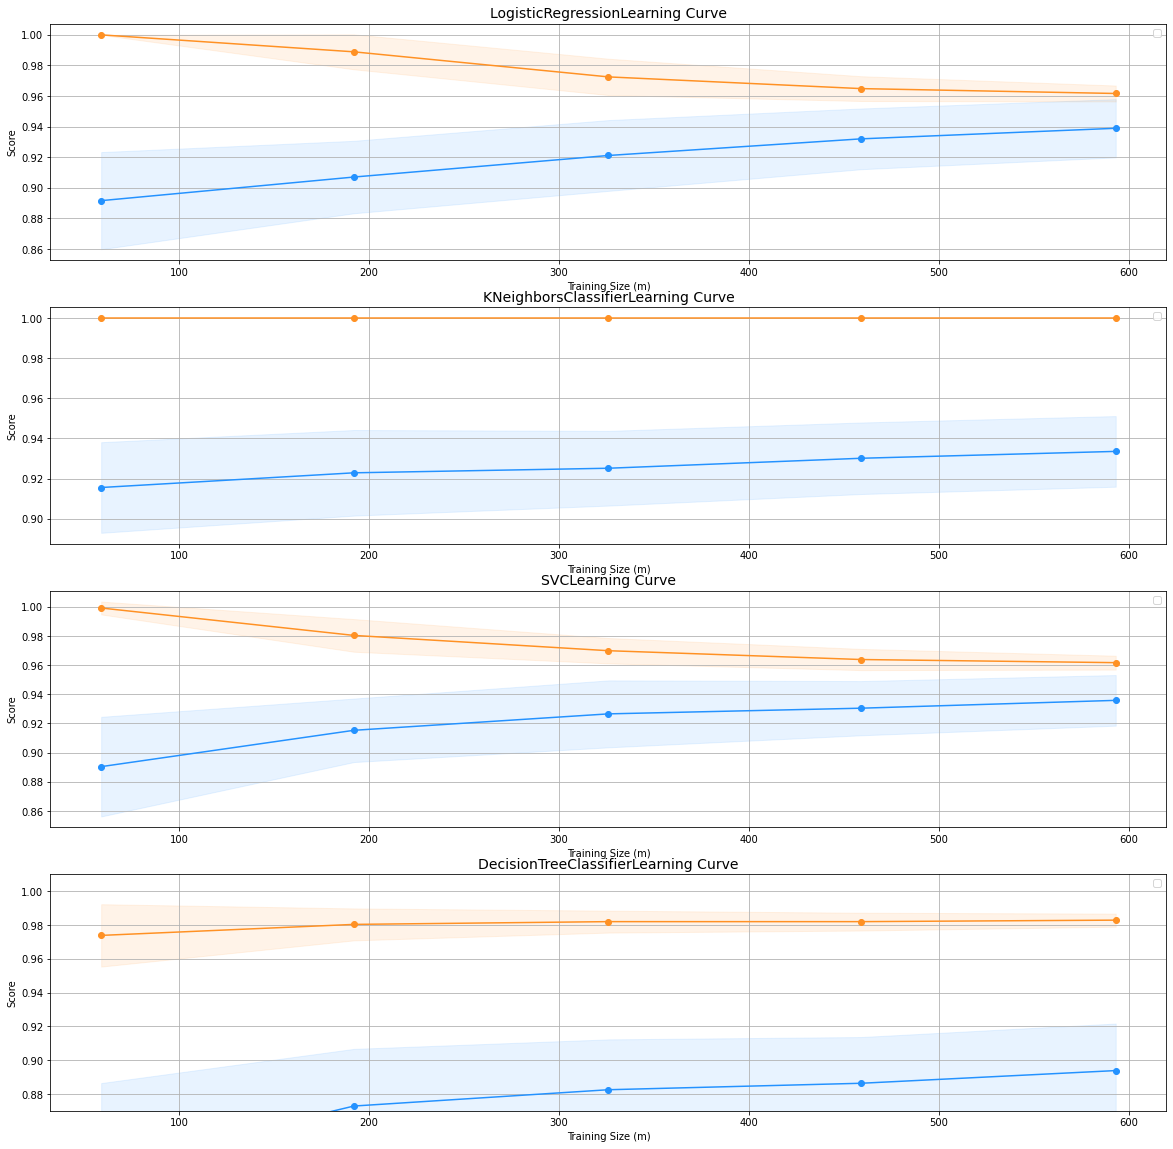

In [34]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plotLearningCurve(
    [log_reg, k_near_neigh, svc_best, dtc_best],
    X_train,
    y_train,
    (0.87, 1.01),
    cv=cv,
    n_jobs=4
)

**Conclusion**
1. **Logistic Regression** has a decent curve not a high or low bias.
2. **K Near Neighbor and Simple Vector Classifier** has a high bias.
3. **Decision Tree Classifier** has high variance.

<span> 
## E. AUC-ROC Curve
</span>

**What is AUC-ROC Curve?**

AUC-ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. **Higher the AUC, better the model is at predicting 0's as 0s and 1s as 1s**. By analogy, Higher the AUC, better the model is at distinguishing between patients with disease and no disease.

AUC-ROC Curve has been explained in a very simple way **[here](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)**

In [35]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5, method='decision_function')
k_near_neigh_pred = cross_val_predict(log_reg, X_train, y_train, cv=5)
svc_pred = cross_val_predict(svc_best, X_train, y_train, cv=5, method="decision_function")
dtc_pred = cross_val_predict(svc_best, X_train, y_train, cv=5)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [36]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, k_near_neigh_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, dtc_pred))

Logistic Regression:  0.968940303394085
KNears Neighbors:  0.9437993379169849
Support Vector Classifier:  0.9734803012113936
Decision Tree Classifier:  0.9413037942449706


4


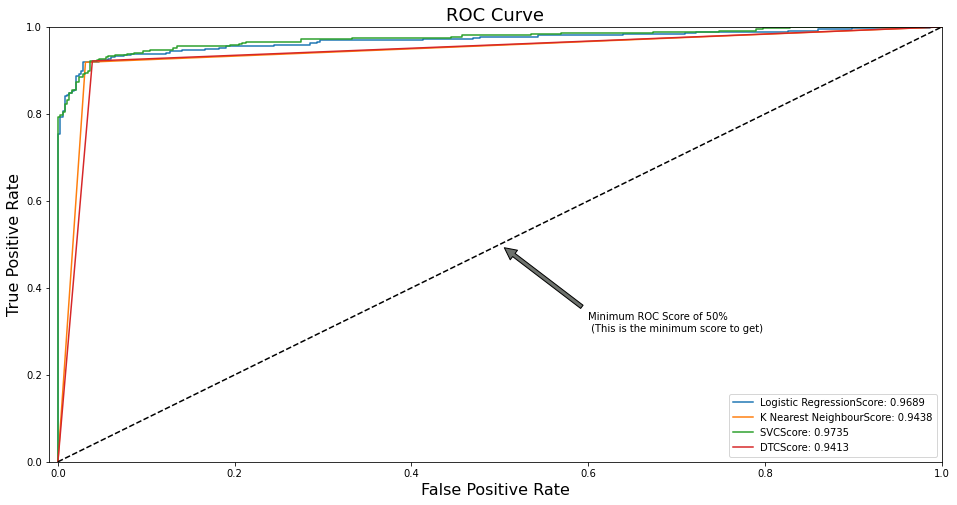

In [37]:
l = []
predictors = [log_reg_pred, k_near_neigh_pred, svc_pred, dtc_pred]
for each in predictors:
    l.append(roc_curve(y_train, each))

labels_for_title = ['Logistic Regression', 'K Nearest Neighbour', 'SVC', 'DTC']

plt.figure(figsize=(16, 8))
plt.title('ROC Curve', fontsize=18)

print(len(l))

for i in range(len(l)):
    plt.plot(
        l[i][0], 
        l[i][1], 
        label=labels_for_title[i]+'Score: {:.4f}'.format(
            roc_auc_score(
                y_train, 
                predictors[i]
            )
        )
    )
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.annotate(
    'Minimum ROC Score of 50% \n (This is the minimum score to get)', 
    xy=(0.5, 0.5), 
    xytext=(0.6, 0.3),
    arrowprops=dict(
        facecolor='#6E726D', 
        shrink=0.05
    )
)
plt.legend()

plt.show()

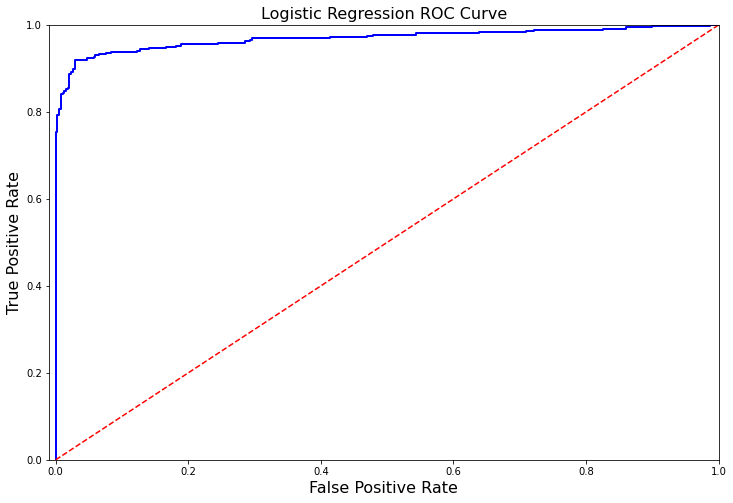

In [38]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)

plt.figure(figsize=(12,8))
plt.title('Logistic Regression ROC Curve', fontsize=16)
plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.axis([-0.01,1,0,1])
plt.show()

<span style='color:red'> 
**SMOTE to be continued**
<span>